In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib notebook

In [2]:
# Load the spam data
data = pd.read_csv('../data/spam.data',sep=' ',header=None)
train_test = pd.read_csv('../data/spam.traintest',header=None)

# Split in train/test
train_data = data[train_test.values==0]
test_data = data[train_test.values==1]

In [3]:
X_train = train_data.iloc[:,0:56].values
y_train = train_data.iloc[:,57].values

X_test = test_data.iloc[:,0:56].values
y_test = test_data.iloc[:,57].values

## Linear regression (OLS)

In [13]:
# Linear regression OLS
import statsmodels.api as sm
X_train_ols = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_ols)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     72.15
Date:                Sat, 09 Mar 2019   Prob (F-statistic):               0.00
Time:                        15:55:13   Log-Likelihood:                -853.65
No. Observations:                3065   AIC:                             1821.
Df Residuals:                    3008   BIC:                             2165.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2088      0.014     15.005      0.0

In [5]:
# Linear regression
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error,r2_score
# Predict test data
y_pred = np.array(regr.predict(X_test) > 0.5, dtype=int)

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 0.13
Variance score: 0.47


In [6]:
# Linear regression and OLS different modules give same answer: self-consistent
# One can compare the coefficients and they are same

## Best subset selection (Backward-stepwise)

In [7]:
from sklearn.metrics import r2_score
n_features = X_train.shape[1]+1

removed_feature_r2 = np.zeros((n_features,3))


y_train_ss = y_train
feature_to_remove = np.NaN

for ind in range(n_features):
    
    if np.isnan(feature_to_remove):
        X_train_ols_ss = sm.add_constant(X_train)
        X_test_ols_ss = sm.add_constant(X_test)
    else:
        X_train_ols_ss = np.delete(X_train_ols_ss,feature_to_remove,1)
        X_test_ols_ss = np.delete(X_test_ols_ss,feature_to_remove,1)

    model = sm.OLS(y_train, X_train_ols_ss)
    results = model.fit()
    y_pred = results.predict(X_test_ols_ss)

    removed_feature_r2[ind,0] = feature_to_remove
    removed_feature_r2[ind,1] = results.rsquared_adj
    removed_feature_r2[ind,2] = mean_squared_error(y_test, y_pred)

    feature_to_remove = np.argmin(results.tvalues)


<IPython.core.display.Javascript object>


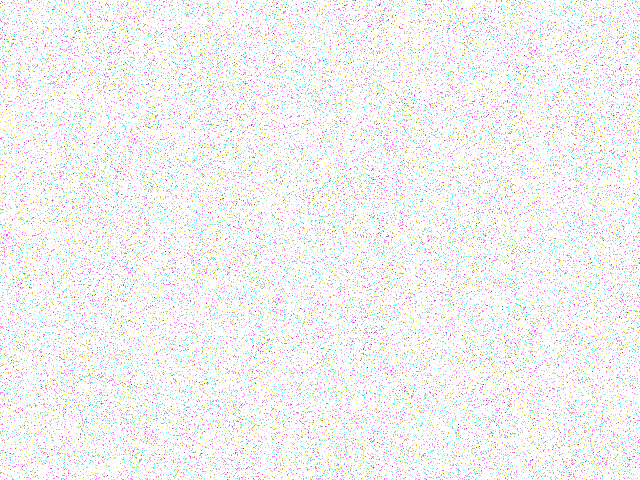

In [8]:
fig,ax = plt.subplots()
ax.plot(removed_feature_r2[:,1],'ro')
# ax.plot(removed_feature_r2[:,1],'ro')

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

n_features = X_train.shape[1]+1

removed_feature_r2 = np.zeros((n_features-1,2))
X_train_ols_ss = sm.add_constant(X_train)

for nf in range(1,n_features):
    
    X_new = SelectKBest(chi2, k=nf).fit_transform(X_train_ols_ss, y_train)
    
    model = sm.OLS(y_train, X_new)
    results = model.fit()
    
    removed_feature_r2[nf-1,0] = feature_to_remove
    removed_feature_r2[nf-1,1] = results.rsquared_adj

<IPython.core.display.Javascript object>


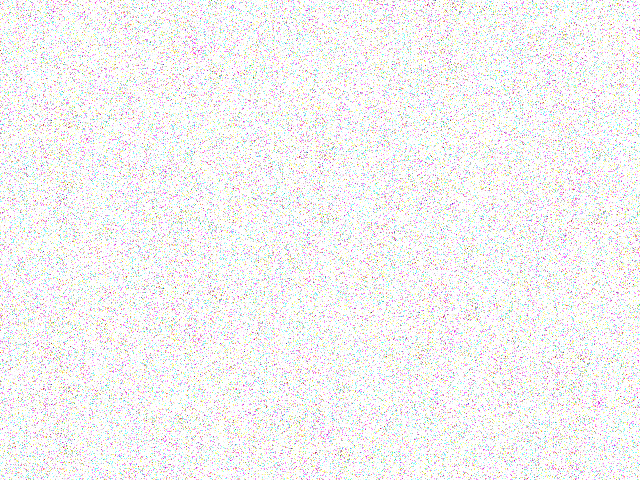

In [16]:
fig,ax = plt.subplots()
ax.plot(removed_feature_r2[:,1],'ro')
# ax.plot(removed_feature_r2[:,1],'ro')

In [18]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     140.7
Date:                Sat, 09 Mar 2019   Prob (F-statistic):               0.00
Time:                        15:56:42   Log-Likelihood:                -964.28
No. Observations:                3065   AIC:                             2041.
Df Residuals:                    3009   BIC:                             2378.
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0143      0.019     -0.733      0.4

## Ridge regression: Using cross validation to find optimal regularization

### Using Ridge and Lasso

<IPython.core.display.Javascript object>


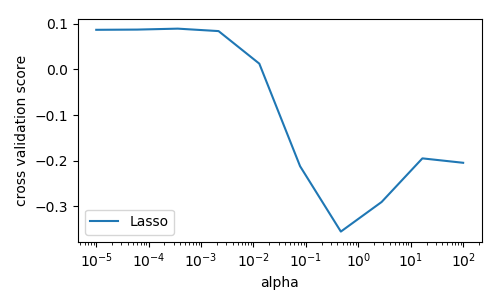

/home/amit/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [80]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso

alphas = np.logspace(-5, 2, 10)

plt.figure(figsize=(5, 3))

for Model in [Lasso]:
    scores = [cross_val_score(Model(alpha), X_train, y_train, cv=3).mean()
            for alpha in alphas]
    plt.plot(alphas, scores, label=Model.__name__)

plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()
plt.xscale('log')

<IPython.core.display.Javascript object>


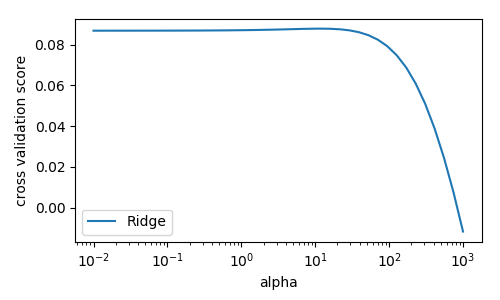

In [79]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso

alphas = np.logspace(-2, 3, 40)

plt.figure(figsize=(5, 3))

for Model in [Ridge]:
    scores = [cross_val_score(Model(alpha), X_train, y_train, cv=3).mean()
            for alpha in alphas]
    plt.plot(alphas, scores, label=Model.__name__)

plt.legend(loc='lower left')
plt.xlabel('alpha')
plt.ylabel('cross validation score')
plt.tight_layout()
plt.show()
plt.xscale('log')

## LASSO

In [56]:
from sklearn.linear_model import Lasso

alphas = np.logspace(-4, -0.5, 30)
mse = np.zeros(alphas.shape)
for ind,alpha in enumerate(alphas):
    clf = Lasso(alpha=alpha)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    mse[ind] = mean_squared_error(y_test,y_pred)

<IPython.core.display.Javascript object>


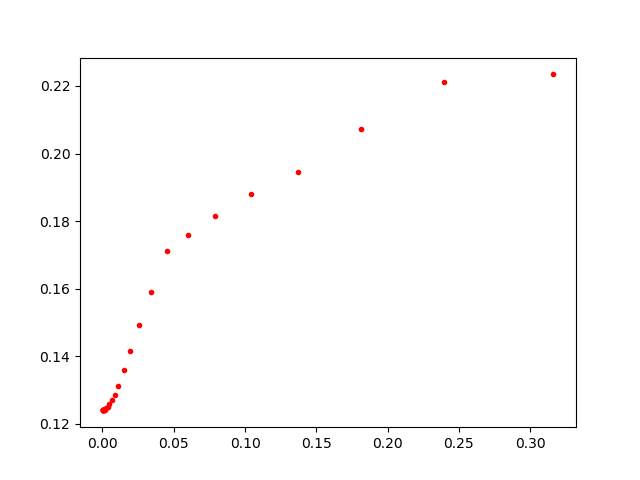

In [57]:
fig,ax = plt.subplots()
ax.plot(alphas,mse,'r.')